### 1. Install Required Dependencies

In [ ]:
!pip install sentence-transformers
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

### 2. Mount drive & Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Intro_to_Machine_Learning/politifact_factcheck_data.json', lines=True)
df['verdict'].value_counts()

### 3. Preprocess (Label Binarization)

In [ ]:
print(len(df))
df = df[df['verdict'] != 'half-true'].reset_index(drop=True)
df = df[df['verdict'] != 'mostly-false'].reset_index(drop=True)
print(len(df))

21152
14123


In [ ]:
# Binarize the labels
binary_map = {
    'true': 0,
    'mostly-true': 0,
    'false': 1,
    'pants-fire': 1
}
df['binary_verdict'] = df['verdict'].map(binary_map)
df['binary_verdict'].value_counts()

,count
binary_verdict,
1,8328
0,5795


Discard unused properties (e.g., `factcheck_date`, `factcheck_analysis_link`, etc.)

In [ ]:
df = df.drop(['factchecker', 'factcheck_date', 'factcheck_analysis_link'], axis=1)
df.head(3)

,verdict,statement_originator,statement,statement_date,statement_source,binary_verdict
0,true,Barack Obama,John McCain opposed bankruptcy protections for...,6/11/2008,speech,0
1,false,Matt Gaetz,"""Bennie Thompson actively cheer-led riots in t...",6/7/2022,television,1
2,mostly-true,Kelly Ayotte,"Says Maggie Hassan was ""out of state on 30 day...",5/18/2016,news,0


Split entire dataset by `train` : `valid` : `test` = 8 : 1 : 1

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['binary_verdict'])
valid_df, test_df = train_test_split(valid_df, test_size=0.5, random_state=42, stratify=valid_df['binary_verdict'])
print(len(train_df), len(valid_df), len(test_df))

11298 1412 1413


### 4. Baseline | Sentence BERT embedding w/ simple metadata encoding


#### 4-1. Get `statement_year` from `statement_date`

In [ ]:
train_df['statement_year'] = train_df['statement_date'].str.split('/').str[-1]
valid_df['statement_year'] = valid_df['statement_date'].str.split('/').str[-1]
test_df['statement_year'] = test_df['statement_date'].str.split('/').str[-1]
train_df.drop('statement_date', axis=1, inplace=True)
valid_df.drop('statement_date', axis=1, inplace=True)
test_df.drop('statement_date', axis=1, inplace=True)

#### 4-2. Extract Sentence BERT embedding from each statement

In [ ]:
from sentence_transformers import SentenceTransformer
sbert_model_name = 'all-MiniLM-L6-v2'
sbert_model = SentenceTransformer(sbert_model_name)

In [ ]:
train_statement_embeddings = sbert_model.encode(train_df['statement'].tolist(), show_progress_bar=True)
valid_statement_embeddings = sbert_model.encode(valid_df['statement'].tolist(), show_progress_bar=True)
test_statement_embeddings = sbert_model.encode(test_df['statement'].tolist(), show_progress_bar=True)

In [ ]:
embedding_dim = train_statement_embeddings.shape[1]
embedding_feature_names = [f'embed_{i}' for i in range(embedding_dim)]
train_embeddings_df = pd.DataFrame(train_statement_embeddings, columns=embedding_feature_names, index=train_df.index)
valid_embeddings_df = pd.DataFrame(valid_statement_embeddings, columns=embedding_feature_names, index=valid_df.index)
test_embeddings_df = pd.DataFrame(test_statement_embeddings, columns=embedding_feature_names, index=test_df.index)

# Combine embeddings with the original DataFrame
train_df = pd.concat([train_df.drop(['statement'], axis=1), train_embeddings_df], axis=1)
valid_df = pd.concat([valid_df.drop(['statement'], axis=1), valid_embeddings_df], axis=1)
test_df = pd.concat([test_df.drop(['statement'], axis=1), test_embeddings_df], axis=1)
train_df.head()

,verdict,statement_originator,statement_source,binary_verdict,statement_year,embed_0,embed_1,embed_2,embed_3,embed_4,...,embed_374,embed_375,embed_376,embed_377,embed_378,embed_379,embed_380,embed_381,embed_382,embed_383
5161,false,Scott Walker,news,1,2011,-0.055342,0.029324,0.016157,0.037620,0.004032,...,-0.049894,-0.040692,-0.023578,0.070436,-0.057112,-0.054528,0.056940,-0.039115,0.010386,-0.034721
10333,false,Facebook posts,social_media,1,2020,0.008371,0.070577,0.059364,0.011913,0.027253,...,-0.027812,-0.004499,0.046334,-0.033792,-0.057582,-0.039001,0.059064,0.010713,0.069696,0.026547
12896,mostly-true,Donald Trump,campaign,0,2020,-0.005775,0.081369,0.091523,0.037719,0.041166,...,-0.088440,0.016320,-0.051128,-0.078806,-0.012644,-0.042643,0.034212,-0.078945,-0.025310,-0.005026
409,pants-fire,Donald Trump,speech,1,2020,-0.084947,0.077394,0.080611,-0.003112,-0.010916,...,0.116466,0.108275,0.043569,0.019466,0.020980,0.043026,-0.022040,-0.025539,0.006419,-0.010950
12078,true,Tim Kaine,news,0,2021,-0.063232,0.078880,0.012146,0.002512,-0.013513,...,0.002505,-0.029684,0.064795,0.037255,-0.088508,-0.100266,-0.015884,0.021775,0.079951,0.031500


In [ ]:
y_train = train_df.binary_verdict
y_valid = valid_df.binary_verdict
y_test = test_df.binary_verdict
X_train = train_df.drop(['verdict', 'statement_originator', 'binary_verdict'], axis=1)
X_valid = valid_df.drop(['verdict', 'statement_originator', 'binary_verdict'], axis=1)
X_test = test_df.drop(['verdict', 'statement_originator', 'binary_verdict'], axis=1)
X_train.head()

,statement_source,statement_year,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,...,embed_374,embed_375,embed_376,embed_377,embed_378,embed_379,embed_380,embed_381,embed_382,embed_383
5161,news,2011,-0.055342,0.029324,0.016157,0.037620,0.004032,0.024392,0.087365,-0.008813,...,-0.049894,-0.040692,-0.023578,0.070436,-0.057112,-0.054528,0.056940,-0.039115,0.010386,-0.034721
10333,social_media,2020,0.008371,0.070577,0.059364,0.011913,0.027253,-0.036312,0.106571,-0.006573,...,-0.027812,-0.004499,0.046334,-0.033792,-0.057582,-0.039001,0.059064,0.010713,0.069696,0.026547
12896,campaign,2020,-0.005775,0.081369,0.091523,0.037719,0.041166,0.063546,-0.017020,0.008552,...,-0.088440,0.016320,-0.051128,-0.078806,-0.012644,-0.042643,0.034212,-0.078945,-0.025310,-0.005026
409,speech,2020,-0.084947,0.077394,0.080611,-0.003112,-0.010916,0.026685,0.019391,-0.007938,...,0.116466,0.108275,0.043569,0.019466,0.020980,0.043026,-0.022040,-0.025539,0.006419,-0.010950
12078,news,2021,-0.063232,0.078880,0.012146,0.002512,-0.013513,0.008941,0.043066,0.027982,...,0.002505,-0.029684,0.064795,0.037255,-0.088508,-0.100266,-0.015884,0.021775,0.079951,0.031500


#### 4-3. Encode & Scale (BERT, `source`, `year`)

In [ ]:
bert_cols = [f'embed_{i}' for i in range(384)]
bert_scaler = StandardScaler()
X_train_bert_scaled_np = bert_scaler.fit_transform(X_train[bert_cols])
X_valid_bert_scaled_np = bert_scaler.transform(X_valid[bert_cols])
X_test_bert_scaled_np = bert_scaler.transform(X_test[bert_cols])

X_train = X_train.drop(bert_cols, axis=1)
X_valid = X_valid.drop(bert_cols, axis=1)
X_test = X_test.drop(bert_cols, axis=1)
print(X_train_bert_scaled_np[0][:10])

[-1.0944536  -0.04076888  0.10614742  0.23786393 -0.2623048   0.03971124
  0.96312314  0.16481827  1.4424397  -0.96911585]


In [ ]:
source_encoder = OneHotEncoder(
    sparse_output=False,
    handle_unknown="ignore"
)

X_train_src_np = source_encoder.fit_transform(X_train[['statement_source']])
X_valid_src_np = source_encoder.transform(X_valid[['statement_source']])
X_test_src_np = source_encoder.transform(X_test[['statement_source']])
X_train = X_train.drop(['statement_source'], axis=1)
X_valid = X_valid.drop(['statement_source'], axis=1)
X_test = X_test.drop(['statement_source'], axis=1)
X_train_src_np[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
year_encoder = OneHotEncoder(
    sparse_output=False,
    handle_unknown="ignore"
)

X_train_year_np = year_encoder.fit_transform(X_train[['statement_year']])
X_valid_year_np = year_encoder.transform(X_valid[['statement_year']])
X_test_year_np = year_encoder.transform(X_test[['statement_year']])
X_train = X_train.drop(['statement_year'], axis=1)
X_valid = X_valid.drop(['statement_year'], axis=1)
X_test = X_test.drop(['statement_year'], axis=1)
X_train_year_np[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
X_train_final = np.concatenate(
    (X_train_src_np, X_train_year_np, X_train_bert_scaled_np),
    axis=1
)
X_valid_final = np.concatenate(
    (X_valid_src_np, X_valid_year_np, X_valid_bert_scaled_np),
    axis=1
)
X_test_final = np.concatenate(
    (X_test_src_np, X_test_year_np, X_test_bert_scaled_np),
    axis=1
)
print(X_train_final.shape)
print(X_valid_final.shape)
print(X_test_final.shape)

(11298, 414)
(1412, 414)
(1413, 414)


#### 4-4. Classifier : MLP

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train_final, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid_final, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.to_numpy(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_final, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=256)
test_loader = DataLoader(test_dataset, batch_size=256)

print(len(train_dataset), len(valid_dataset), len(test_dataset))
data, label = next(iter(train_dataset))
print(data.shape, label)

11298 1412 1413
torch.Size([414]) tensor(1.)


In [ ]:
# Define MLP-based model
class MLPBatchNorm1D(nn.Module):
    def __init__(self, input_dim, dropout_ratios):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_ratios[0]),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_ratios[1]),

            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(dropout_ratios[2]),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
## ----- CONFIG ----- ##
# model params
LR = 1e-3
DROPOUT_RATIOS = [0.6, 0.5, 0.4]
INPUT_DIM = X_train_tensor.shape[1]

# training params
NUM_EPOCHS = 30
best_loss = float('inf')
epochs_no_improve = 0
early_stop = 10
last_lr = LR
## ------------------ ##

model = MLPBatchNorm1D(INPUT_DIM, DROPOUT_RATIOS)
best_model = MLPBatchNorm1D(INPUT_DIM, DROPOUT_RATIOS)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
import copy

for i, epoch in enumerate(range(NUM_EPOCHS)):
    train_losses = []
    valid_losses = []

    # Train mode
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb).squeeze()
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        train_losses.append(loss)

    print(f"Epoch {epoch} | Train Loss: {(sum(train_losses)/len(train_losses)):.4f}", end=" | ")

    # Validation mode
    model.eval()
    with torch.no_grad():
      for xb, val_yb in valid_loader:
        val_preds = model(xb).squeeze()
        val_loss = criterion(val_preds, val_yb)
        valid_losses.append(val_loss)

    epoch_valid_loss = (sum(valid_losses)/len(valid_losses))
    print(f"Valid Loss: {epoch_valid_loss:.4f}")

    if epoch_valid_loss < best_loss:
        best_loss = epoch_valid_loss
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
        print(f"Updating best model @ Epoch = {i}")

    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop:
            print("Early stopping triggered.")
            break

    del train_losses, valid_losses

print("Done")

Epoch 0 | Train Loss: 0.5896 | Valid Loss: 0.5376
Updating best model @ Epoch = 0
Epoch 1 | Train Loss: 0.5232 | Valid Loss: 0.5194
Updating best model @ Epoch = 1
Epoch 2 | Train Loss: 0.4930 | Valid Loss: 0.5146
Updating best model @ Epoch = 2
Epoch 3 | Train Loss: 0.4808 | Valid Loss: 0.5169
Epoch 4 | Train Loss: 0.4646 | Valid Loss: 0.5147
Epoch 5 | Train Loss: 0.4489 | Valid Loss: 0.5228
Epoch 6 | Train Loss: 0.4455 | Valid Loss: 0.5163
Epoch 7 | Train Loss: 0.4226 | Valid Loss: 0.5260
Epoch 8 | Train Loss: 0.4171 | Valid Loss: 0.5190
Epoch 9 | Train Loss: 0.3978 | Valid Loss: 0.5434
Epoch 10 | Train Loss: 0.4001 | Valid Loss: 0.5295
Epoch 11 | Train Loss: 0.3783 | Valid Loss: 0.5324
Epoch 12 | Train Loss: 0.3759 | Valid Loss: 0.5451
Early stopping triggered.
Done


### 5. Evaluation and save results

In [ ]:
best_model.load_state_dict(best_model_state)
best_model.eval()

with torch.no_grad():
    test_preds_probs_best = best_model(X_test_tensor)
    test_preds_best = (test_preds_probs_best).round().squeeze()

print(classification_report(y_test_tensor, test_preds_best))

              precision    recall  f1-score   support

         0.0       0.67      0.74      0.70       580
         1.0       0.81      0.74      0.77       833

    accuracy                           0.74      1413
   macro avg       0.74      0.74      0.74      1413
weighted avg       0.75      0.74      0.74      1413



[*] Baseline : AP = 0.871, AUC = 0.809
--------------------------------------------------


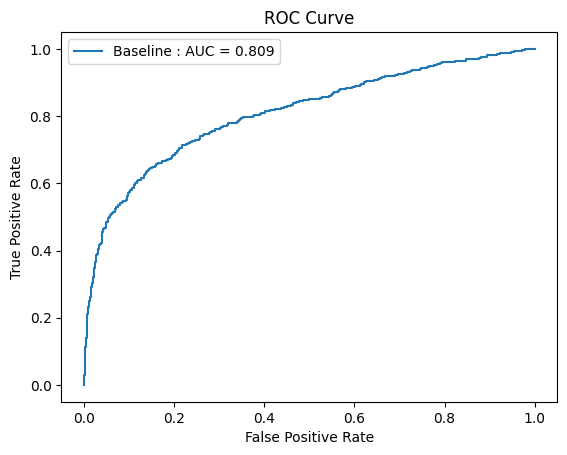

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score

def evaluate_ap_and_auroc(test_labels, test_preds, exp_names):
  '''
  Calulate AUROC and Average Precsion from model predictions

  INPUT
      - test_labels : binary verdicts from test set / list(np.ndarray)
      - test_preds : 'probability' predictions of the model on test set / list(np.npdarray)
      - exp_names : name of each experiment / list(string)
  '''

  assert len(test_labels) == len(test_preds) and len(test_labels) == len(exp_names), \
          "Length of each list should be identical."

  for labels, preds, exp_name in zip(test_labels, test_preds, exp_names):
    fpr, tpr, thresholds = roc_curve(labels, preds)
    auc = roc_auc_score(labels, preds)
    ap = average_precision_score(labels, preds)
    plt.plot(fpr, tpr, label=f'{exp_name} : AUC = {auc:.3f}')
    print(f"[*] {exp_name} : AP = {ap:.3f}, AUC = {auc:.3f}")

  print("-" * 50)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend()
  plt.show()


test_preds = [test_preds_probs_best]
test_labels = [y_test_tensor.numpy()] * len(test_preds)
exp_names = ['Baseline']

evaluate_ap_and_auroc(test_labels, test_preds, exp_names)

(Optional) Save model predictions for further comparison

In [ ]:
EXP_NAME = "baseline_mlp"
PATH = f"/content/drive/MyDrive/Colab Notebooks/Intro_to_Machine_Learning/weights/{EXP_NAME}_best_preds.npy"
test_preds_probs_best_np = test_preds_probs_best.detach().cpu().numpy()

with open(PATH, 'wb') as f:
    np.save(f, test_preds_probs_best_np)